# GAN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## The Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


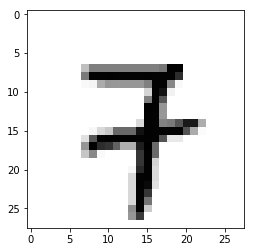

In [3]:
plt.imshow(mnist.train.images[14].reshape(28,28),cmap='Greys')

## The Generator

In [4]:
def generator(z,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z,units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        hidden2 = tf.layers.dense(inputs=hidden1,units=128)
        
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        output = tf.layers.dense(hidden2,units=784,activation=tf.nn.tanh)
        return output
    

## The Discriminator

In [5]:
def discriminator(X,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X,units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        
        hidden2 = tf.layers.dense(inputs=hidden1,units=128)
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        
        logits = tf.layers.dense(hidden2,units=1)
        output = tf.sigmoid(logits)
    
        return output, logits

### Placeholders

In [6]:
real_images = tf.placeholder(tf.float32,shape=[None,784])
z = tf.placeholder(tf.float32,shape=[None,100])

### Generator

In [7]:
G = generator(z)

### Discriminator 

In [8]:
D_output_real , D_logits_real = discriminator(real_images)

In [9]:
D_output_fake, D_logits_fake = discriminator(G,reuse=True)

### Losses

In [10]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

In [11]:
D_real_loss = loss_func(D_logits_real,tf.ones_like(D_logits_real)* (0.9))

In [12]:
D_fake_loss = loss_func(D_logits_fake,tf.zeros_like(D_logits_real))

In [13]:
D_loss = D_real_loss + D_fake_loss

In [14]:
G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))

### Optimizers

In [15]:
learning_rate = 0.001

In [16]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['dis/dense/kernel:0', 'dis/dense/bias:0', 'dis/dense_1/kernel:0', 'dis/dense_1/bias:0', 'dis/dense_2/kernel:0', 'dis/dense_2/bias:0']
['gen/dense/kernel:0', 'gen/dense/bias:0', 'gen/dense_1/kernel:0', 'gen/dense_1/bias:0', 'gen/dense_2/kernel:0', 'gen/dense_2/bias:0']


In [17]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

## Completion code here

In [18]:
img = tf.placeholder(tf.float32, shape=(1, 784))

In [19]:
mask = np.ones(shape=[28,28], dtype=np.float32)
mask[10:18,10:18] = 0
mask = mask.reshape(1,784)

In [20]:
img_to_correct = tf.multiply(tf.reshape(img, shape=(28,28)), tf.convert_to_tensor(tf.reshape(mask, shape=(28,28))))

In [21]:
z1 = tf.Variable(initial_value = np.random.uniform(-1, 1, size=(1, 100)).astype("float32"), dtype=tf.float32)

In [22]:
G1 = generator(z1, reuse = True)

In [23]:
img_gen_masked = tf.matmul(G1, mask, transpose_b=True)

In [24]:
contextual_loss = tf.reduce_mean(tf.abs(img_gen_masked - img_to_correct))

In [25]:
perceptual_loss = G_loss

In [26]:
complete_loss = contextual_loss + perceptual_loss

In [27]:
complete_loss_trainer = tf.train.AdamOptimizer(learning_rate).minimize(complete_loss, var_list=z1)

## Training Session

In [47]:
batch_size = 100
epochs = 500
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [48]:
# Save a sample per epoch
samples = []
ans_z = []

In [49]:
with tf.Session() as sess:
    
    sess.run(init)
    
    # Recall an epoch is an entire run through the training data
    for e in range(epochs):
        # // indicates classic division
        num_batches = mnist.train.num_examples // batch_size
        
        for i in range(num_batches):
            
            # Grab batch of images
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Z (random latent noise data for Generator)
            # -1 to 1 because of tanh activation
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            # Run optimizers, no need to save outputs, we won't use them
            _ = sess.run(D_trainer, feed_dict={real_images: batch_images, z: batch_z})
            _ = sess.run(G_trainer, feed_dict={z: batch_z})
        
            
        print("Currently on Epoch {} of {} total...".format(e+1, epochs))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(generator(z ,reuse=True),feed_dict={z: sample_z})
        
        samples.append(gen_sample)
        
        _ = sess.run(complete_loss_trainer, feed_dict = {img: mnist.train.images[14].reshape(1, 784)})
        ansz = sess.run(z1)
        ans_z.append(ansz)
        gen_ans = sess.run(generator(z ,reuse=True),feed_dict={z: ansz})
        saver.save(sess, './models/50_epoch_model.ckpt')

Currently on Epoch 1 of 500 total...
Currently on Epoch 2 of 500 total...
Currently on Epoch 3 of 500 total...
Currently on Epoch 4 of 500 total...
Currently on Epoch 5 of 500 total...
Currently on Epoch 6 of 500 total...
Currently on Epoch 7 of 500 total...
Currently on Epoch 8 of 500 total...
Currently on Epoch 9 of 500 total...
Currently on Epoch 10 of 500 total...
Currently on Epoch 11 of 500 total...
Currently on Epoch 12 of 500 total...
Currently on Epoch 13 of 500 total...
Currently on Epoch 14 of 500 total...
Currently on Epoch 15 of 500 total...
Currently on Epoch 16 of 500 total...
Currently on Epoch 17 of 500 total...
Currently on Epoch 18 of 500 total...
Currently on Epoch 19 of 500 total...
Currently on Epoch 20 of 500 total...
Currently on Epoch 21 of 500 total...
Currently on Epoch 22 of 500 total...
Currently on Epoch 23 of 500 total...
Currently on Epoch 24 of 500 total...
Currently on Epoch 25 of 500 total...
Currently on Epoch 26 of 500 total...
Currently on Epoch 27

Currently on Epoch 214 of 500 total...
Currently on Epoch 215 of 500 total...
Currently on Epoch 216 of 500 total...
Currently on Epoch 217 of 500 total...
Currently on Epoch 218 of 500 total...
Currently on Epoch 219 of 500 total...
Currently on Epoch 220 of 500 total...
Currently on Epoch 221 of 500 total...
Currently on Epoch 222 of 500 total...
Currently on Epoch 223 of 500 total...
Currently on Epoch 224 of 500 total...
Currently on Epoch 225 of 500 total...
Currently on Epoch 226 of 500 total...
Currently on Epoch 227 of 500 total...
Currently on Epoch 228 of 500 total...
Currently on Epoch 229 of 500 total...
Currently on Epoch 230 of 500 total...
Currently on Epoch 231 of 500 total...
Currently on Epoch 232 of 500 total...
Currently on Epoch 233 of 500 total...
Currently on Epoch 234 of 500 total...
Currently on Epoch 235 of 500 total...
Currently on Epoch 236 of 500 total...
Currently on Epoch 237 of 500 total...
Currently on Epoch 238 of 500 total...
Currently on Epoch 239 of

KeyboardInterrupt: 

In [50]:
with tf.Session() as sess:
    img_to_corr = sess.run(img_to_correct, feed_dict = {img: mnist.train.images[14].reshape(1, 784)})

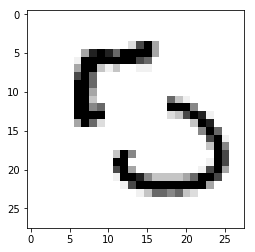

In [51]:
plt.imshow(img_to_corr,cmap='Greys')

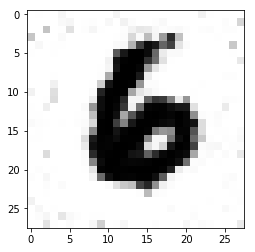

In [52]:
plt.imshow(gen_ans.reshape(28,28),cmap='Greys')

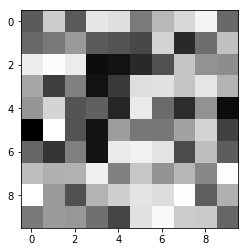

In [53]:
plt.imshow(ans_z[99].reshape(10,10),cmap='Greys')

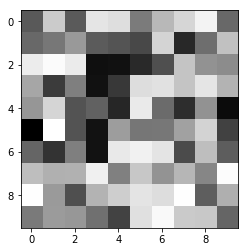

In [54]:
plt.imshow(ans_z[95].reshape(10,10),cmap='Greys')